In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
#from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
from xlrd.biffh import BIFF_FIRST_UNICODE
import xlwt
from scipy.stats import norm
from cycler import cycler
#import seaborn as sns
import dynamic_stock_model as dsm

In [2]:
# Loading data
path = os.getcwd()
data = pd.read_csv(path+"/data/Supplementary_information/dummy_data_battery.csv", header=0 , sep=',')
# This is just to replace all the void values in "data" by 0, which makes things easier
data.fillna(0, inplace=True)

# We store the time and inflows values in two lists
time = data['Time'].tolist()
stock_cars = data['Population'].tolist() 
years = len(time)

Text(0, 0.5, 'Batteries, Cars / Year')

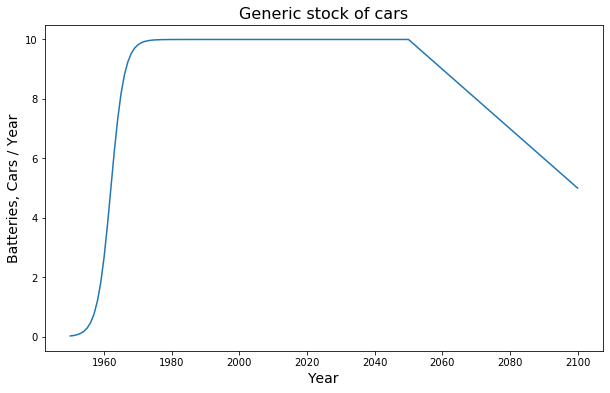

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(time, stock_cars)
plt.title('Generic stock of cars', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)


## Case 1
Products have a lifetime that includes all types of failures, component EoL being one of them. No component replacement. 1 product = one component, Outflow component = outflow product 

Since this case includes all possible failures, the choice of lifetime should not be limted to the technical lifetime of the product itself but should also consider how this might be 
affected by failures in the component and potential damages. Therefore, the probability that a failure occurs is greater than the techical lifetime of the product itself and should lead
to a shorter choice of lifetime. 

This approach is equivalent as the traditional one-lifetime approach used in dynamic models.

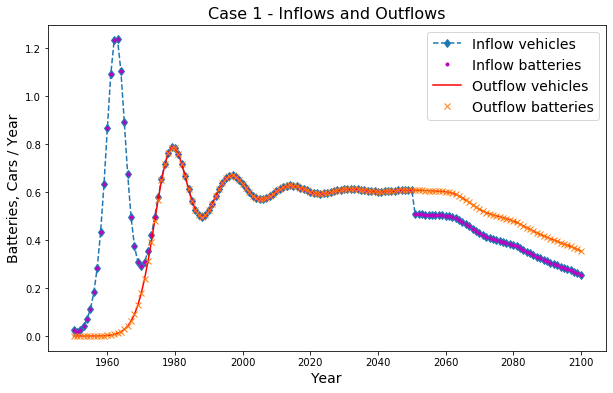

In [4]:
import product_component_model as pcm
Model1 = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)

Model1.case_1()
# Inflows and Outflows for the battery model
plt.figure(figsize=(10, 6))
plt.plot(time, Model1.i_pr, 'd--', label='Inflow vehicles')
plt.plot(time, Model1.i_cm, 'm.', label='Inflow batteries ')
plt.plot(time, Model1.oc_pr.sum(axis=1),'r', label='Outflow vehicles')
plt.plot(time, Model1.oc_cm.sum(axis=1),'x', label='Outflow batteries')
plt.title('Case 1 - Inflows and Outflows', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

## Case 2
Products have a lifetime that includes all types of failures, component EoL being one of them. Still, it is assumed that some components will be replaced at a given rate replacement_coeff. 
More than one component is used in the lifetime of the product. Outflow component >= outflow product

In this case the failure of components is accounted for by a replacement rate and therefore the lifetime of the vehicle can be assumed to not be affected to the same extent as in case 1. 
Limitations to this approach might be that the outflows and component inflows are estimated at different times as the case where a separate lifetime would be calculated for the components. 
It is more suitable if the stock is approximately constant.  

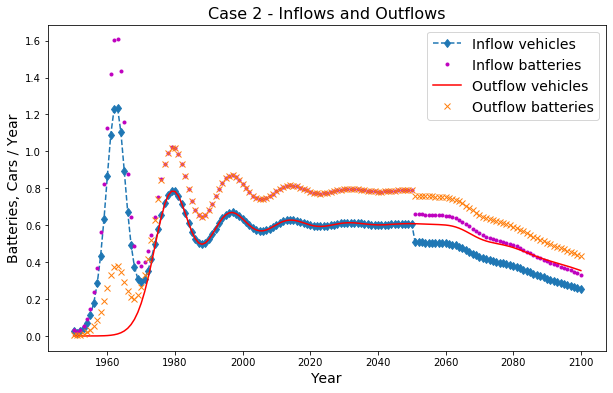

In [5]:
Model1 = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model1.case_2()
# Inflows and Outflows for the battery model
plt.figure(figsize=(10, 6))
plt.plot(time, Model1.i_pr, 'd--', label='Inflow vehicles')
plt.plot(time, Model1.i_cm, 'm.', label='Inflow batteries ')
plt.plot(time, Model1.o_pr,'r', label='Outflow vehicles')
plt.plot(time, Model1.o_cm,'x', label='Outflow batteries')
plt.title('Case 2 - Inflows and Outflows', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

## Case 3

Products and components have independent hazard functions. Potential failure of the component is not included in the hazard function of the product. Components can neither be replaced nor reused, meaning that if either the product or the component fail, they are both scrapped.

In this case, the combined hazard functions of the component and the product yield a smaller in-use time that dictates the outflows based on all failures. 
This would be a similar case as 1, but the in-use time is the result of the combined dynamics of the hazard functions.

Double-counting is accounted for by considering the overlapping probability of failure of product and component during the same year.

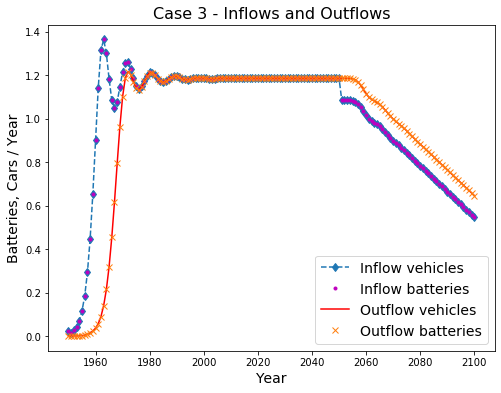

In [6]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_3()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow vehicles')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries ')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow vehicles')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
plt.title('Case 3 - Inflows and Outflows', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Cars / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.show()

## Case 4 
Products and components have independent hazard functions. Potential failure of the component is not included in the hazard function of the product. 
Components cannot be replaced, but they can be reused. If the component fails, the product is scrapped. 

If the product fails but the status of the component is still good, it can be reused in a new product according to the reuse_coeff. 

The stock composition of the product is no longer equal to the stock composition of the component, but the total stock is. 

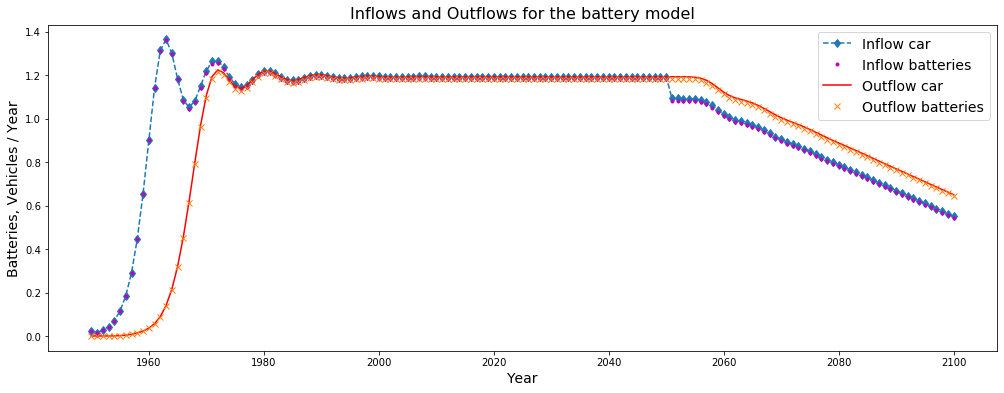

In [7]:
import product_component_model as pcm
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_4()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries, Vehicles / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 5
Products and components have independent hazard functions. Potential failure of the component is not included in the hazard function of the product. 
Components cannot be reused, but they can be replaced. If the component fails, the product is can get a replacement according to the replacement_coeff. 

The stock composition of the product is no longer equal to the stock composition of the component, but the total stock is. 

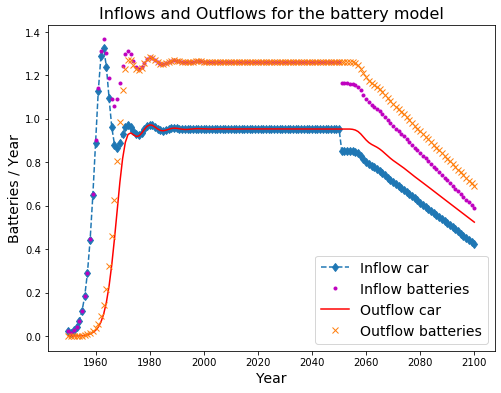

In [8]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_5()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 6
Products and components have independent hazard functions. Potential failure of the component is not included in the hazard function of the product. 
Components can be reused, and they can be replaced. If the component fails, the product is can get a replacement according to the replacement_coeff. 
As a first priority, the replacement component would be a reused one from the same cohort. 

If the reusable components of the same cohort are not enough for the demand of replacement, newer cohorts are used. 

Once all reused components have been installed in replacements, and if there is still a demand for component replacement, new components are used. 

The stock composition of the product is no longer equal to the stock composition of the component, but the total stock is. 

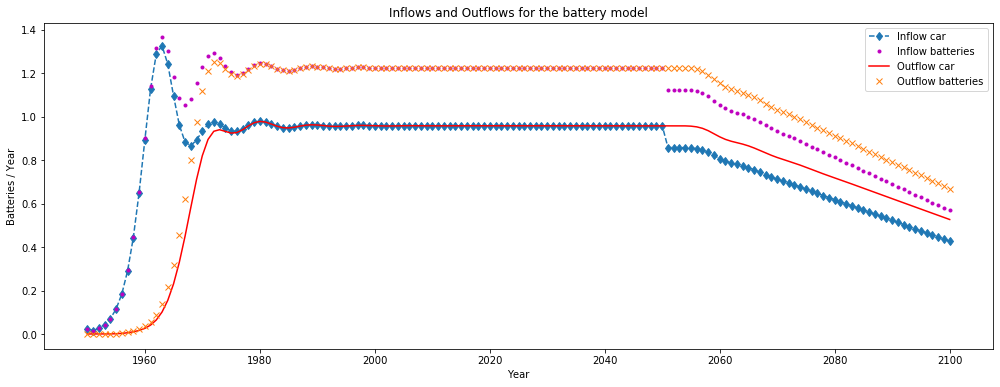

In [9]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_6()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 7
The model does not use lifetimes at all. It would make sense if the inflows of products and components are calculated as a percentage of 
the stock (Stock and birth rate model in the paper Lauinger et al.). OK for models where the stock is stable, not suited for studying the 
penetration of new products and technologies. 1 product = 1 component, no replacements allowed

This model is driven by a death rate. The component outflows and the product outflows are equivalent and 
the rate encompases failures in both products. 

This case computes model using death rate

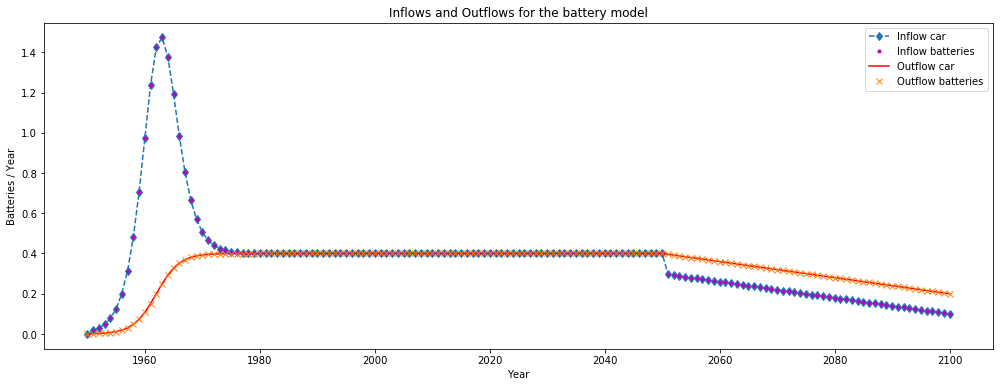

In [10]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_7()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.o_cm,'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

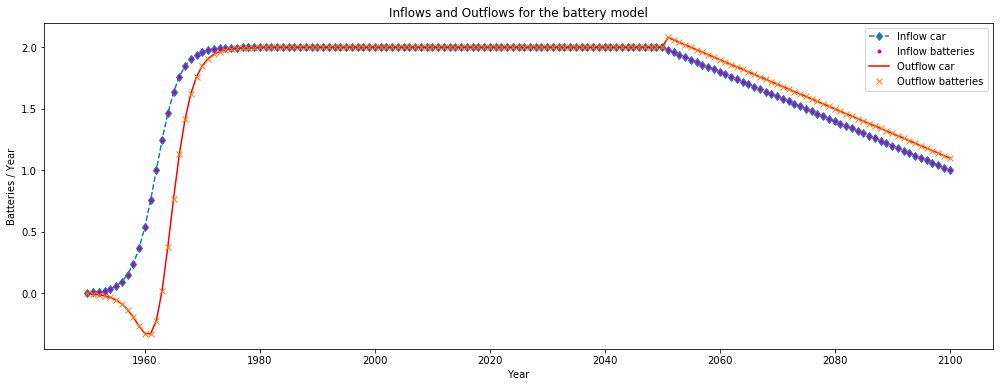

In [11]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3, b=0.2)
Model.case_7b()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.o_cm,'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 8	
The model does not use lifetimes at all. It would make sense if the inflows of products and components are calculated as a percentage of the stock 
(Stock and birth rate model in the paper by Lauinger, Billy, et al.). OK for models where the stock is stable, not suited for studying the penetration of new 
products and technologies. 

In this case, a replacement rate for the component is considered according to the replacement_coeff.

This case computes the model using death rate.

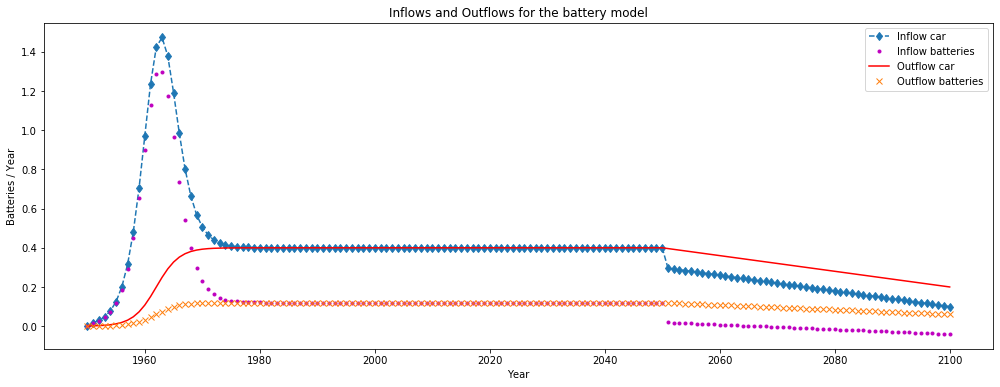

In [12]:
Model = Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_8()
# Inflows and Outflows for the battery model
plt.figure(figsize=(17, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.o_cm,'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model')
plt.xlabel('Year')
plt.ylabel('Batteries / Year')
plt.legend(loc='best')

## Case 9
The lifetime of the product is mostly determined by the lifetime of the component. No component replacement, when it fails, the product fails.  
There should be some extra outflows of products as well (accidents), which could be modelled by a stock and death rate approach. 
1 product = one component, Outflow component = outflow product.  

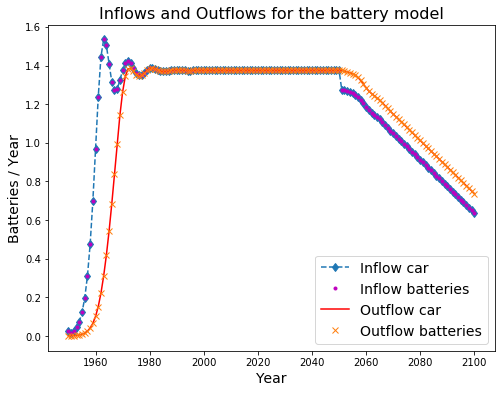

In [13]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_9()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 10 
The lifetime of the product is mostly determined by the lifetime of the component. No component replacement, when it fails, the product fails, 
but some components from failed products can be reused in new products.  There should be some extra outflows of products as well (accidents), 
which could be modelled by a stock and death rate approach. Outflow component <= outflow product. This case is probably not the most meaningful.

In this case some of the components are deemed to be reusable. This makes sense if we consider that some of the outflows are due to product failures. 
We can here consider then that only a fraction of the components that would qualify can actually be reused. We do this by defining a reuse rate of the
components in failed products.

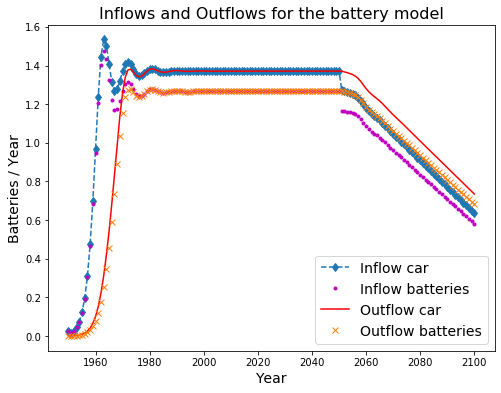

In [14]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_10()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.oc_pr.sum(axis=1),'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 11
The lifetime of the product is mostly determined by the lifetime of the component. 
The component can be replaced, but old components cannot be reused. 
This model assumes that a product would live infinitely as long as the component keeps being replaced.
There should be some extra outflows of products as well (accidents), which could be modelled by a stock and death rate approach. Outflow component >= outflow product.  

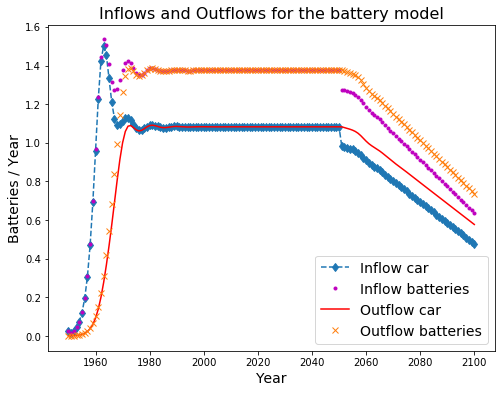

In [15]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_11()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='Inflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)

## Case 12
The lifetime of the product is mostly determined by the lifetime of the component. 
The component can be replaced, and old components can be reused. 
This model assumes that a product would live infinitely as long as the component keeps being replaced. 
There should be some extra outflows of products as well (accidents), which could be modelled by a stock and death rate approach. 
Outflow component <= or >= outflow product depending on assumptions for reuse and replacement.

We take a similar approach to case 6 here, only the products do not have a lifetime and therefore are always elegible to get a component replacement. 

We take the share of components that is exiting use due to product crashes and take a share for reuse according to the reuse_coeff.

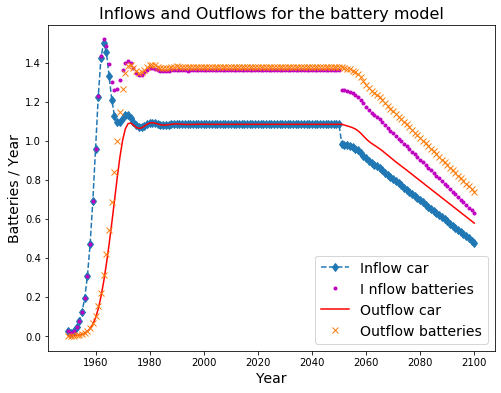

In [16]:
Model = pcm.ProductComponentModel(t=time, s_pr=stock_cars, 
                                  lt_cm={'Type': 'Normal', 'Mean':np.array([8]), 'StdDev': np.array([2])}, 
                                  lt_pr={'Type': 'Normal', 'Mean':np.array([16]), 'StdDev': np.array([4])},
                                  d=0.04, reuse_coeff=0.3, replacement_coeff=0.3)
Model.case_12()
# Inflows and Outflows for the battery model
plt.figure(figsize=(8, 6))
plt.plot(time, Model.i_pr, 'd--', label='Inflow car')
plt.plot(time, Model.i_cm, 'm.', label='I nflow batteries')
plt.plot(time, Model.o_pr,'r', label='Outflow car')
plt.plot(time, Model.oc_cm.sum(axis=1),'x', label='Outflow batteries')
#plt.plot(time, Model4.oc_pr.sum(axis=1)+ Model4.oc_cm.sum(axis=1),'x', label='Outflow batteries')

plt.title('Inflows and Outflows for the battery model', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Batteries / Year', fontsize=14)
plt.legend(loc='best', fontsize=14)